In [2]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from matplotlib import animation
from IPython.display import HTML

In [3]:
def get_loss(x, y):
    def gaussian_hills(x, y, x_mean, y_mean, x_sig, y_sig):
        normalizing = 1 / (2 * np.pi * x_sig * y_sig)
        x_exp = (-1 * (x - x_mean) ** 2) / (2 * x_sig ** 2)
        y_exp = (-1 * (y - y_mean) ** 2) / (2 * y_sig ** 2)
        return normalizing * tf.exp(x_exp + y_exp)
    
    loss = 0.2 * gaussian_hills(x, y, x_mean=-0.8, y_mean=-0.8, x_sig=0.55, y_sig=0.55)
    loss -= 0.2 * gaussian_hills(x, y, x_mean=1.0, y_mean=-0.5, x_sig=0.55, y_sig=0.55)
    loss -= 0.1 * gaussian_hills(x, y, x_mean=-1.0, y_mean=0.5, x_sig=0.55, y_sig=0.55)
    loss -= 0.1 * gaussian_hills(x, y, x_mean=0.5, y_mean=0.8, x_sig=0.5, y_sig=0.5)
    loss -= 0.1 * gaussian_hills(x, y, x_mean=-0.4, y_mean=-0.6, x_sig=0.45, y_sig=0.45)
    return loss

In [5]:
tf.reset_default_graph()
x_var = tf.get_variable(name="x", shape=(), dtype=tf.float32, initializer=tf.constant_initializer(-0.8))
y_var = tf.get_variable(name="y", shape=(), dtype=tf.float32, initializer=tf.constant_initializer(-0.9))
loss = get_loss(x_var, y_var)
adam_opt = tf.train.AdamOptimizer(1e-1).minimize(loss, var_list=[x_var, y_var])
rmsprop_opt = tf.train.RMSPropOptimizer(1e-1).minimize(loss, var_list=[x_var, y_var])
momentum_opt = tf.train.MomentumOptimizer(1e-1, momentum=0.9).minimize(loss, var_list=[x_var, y_var])
adagrad_opt = tf.train.AdagradOptimizer(1e-1).minimize(loss, var_list=[x_var, y_var])
adadelta_opt = tf.train.AdadeltaOptimizer(1e-1).minimize(loss, var_list=[x_var, y_var])
sgd_opt = tf.train.GradientDescentOptimizer(1e-1).minimize(loss, var_list=[x_var, y_var])

colors = "bgrcmykw"
optimizers = list()
for i, opt in enumerate([adam_opt, rmsprop_opt, momentum_opt, adagrad_opt, adadelta_opt, sgd_opt]):
    optimizers.append({"opt": opt, "name": opt.name, "lr": 0.1, "trajectory": list(), "color": colors[i]})
    
num_iters = 200
with tf.Session() as sess:
    for opt in optimizers:
        sess.run(tf.global_variables_initializer())
        opt["trajectory"].append(sess.run([x_var, y_var, loss]))        
        for _ in range(num_iters):
            sess.run(opt["opt"])
            opt["trajectory"].append(sess.run([x_var, y_var, loss]))

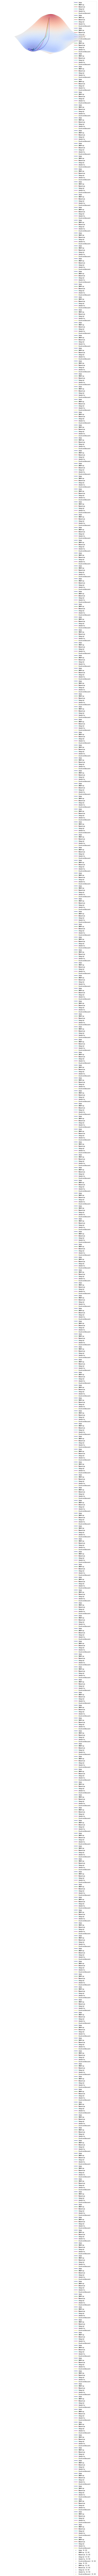

In [6]:
# plot surface
s = 50
x = np.arange(-1.5, 1.5, 3.0 / s)
y = np.arange(-1.5, 1.5, 3.0 / s)
x, y = np.meshgrid(x, y)
x, y = x.reshape(-1), y.reshape(-1)
loss = get_loss(x, y)

tf.reset_default_graph()
with tf.Session() as sess:
    loss = sess.run(get_loss(x, y))
x = x.reshape((s, s))
y = y.reshape((s, s))
loss = loss.reshape((s, s))

fig = plt.figure(figsize=(17, 12))
ax = Axes3D(fig)
ax._axis3don = False
ax.plot_surface(x, y, loss, rstride=1, cstride=1, cmap=plt.get_cmap("coolwarm"), alpha=0.6, zorder=0)
ax.set_zlim(-0.1, 0.12)
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.view_init(elev=45, azim=45)

# plot trajectories
def update_fig(i):
    for opt in optimizers:
        ln = ax.plot(*zip(opt["trajectory"][i], opt["trajectory"][i+1]), color=opt["color"], zorder=10, label=opt["name"], linewidth=3)
    return ln,
        
def init_fig():
    for opt in optimizers:
        ln = ax.scatter(*opt["trajectory"][0], color=opt["color"], zorder=10, label="%s (%.2f)" % (opt["name"], opt["lr"]))
    ax.legend(prop={'size': 20})
    return ()

anim = FuncAnimation(fig, update_fig, frames=num_iters-1, interval=60, init_func=init_fig, repeat=True)
HTML(anim.to_html5_video())
# anim.save('optimization_methods.gif', dpi=36, writer='imagemagick')